# Deploy three models on a single IC-enabled endpoint on SageMaker AI

In this notebook we will show how to deploy 3 different models on the same SageMaker AI endpoint.

We will use 4-GPU `ml.g6e.12xlarge` instance for SageMaker AI real-time endpoint and we will deploy:
- [Qwen3-8B](https://huggingface.co/Qwen/Qwen3-8B)
- [gpt-oss-120b](https://huggingface.co/openai/gpt-oss-120b)
- [Gemma3-4B-it](https://huggingface.co/google/gemma-3-4b-it)

on the same endpoint using SageMaker AI Inference Component feature

We are going to use AWS Python API (`boto3`) for model deployments.

## Step 1: Setup

Fetch and import dependencies

In [ ]:
%pip install sagemaker --upgrade --quiet --no-warn-conflicts

In [ ]:
import time
import json
import sagemaker
import boto3
from IPython.display import display, Markdown

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()

sm_client = boto3.client("sagemaker")  # client to intreract with SageMaker
smr_client = boto3.client("sagemaker-runtime")  # client to intreract with SageMaker Endpoints

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
print(f"sagemaker version: {sagemaker.__version__}")

## Deployment

### Common setup

In [ ]:
CONTAINER_VERSION = "0.34.0-lmi16.0.0-cu128"
inference_image = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:{CONTAINER_VERSION}"

instance = {"type": "ml.g6e.12xlarge", "num_gpu": 4}
endpoint_config_name = endpoint_name = sagemaker.utils.name_from_base("ep-IC")
timeout = 600
variant_name = "main"

In [ ]:
lmi_env = {
    "SERVING_FAIL_FAST": "true",
    "OPTION_ASYNC_MODE": "true",
    "OPTION_ROLLING_BATCH": "disable",
    "OPTION_MAX_MODEL_LEN": "16384",
    "OPTION_ENTRYPOINT": "djl_python.lmi_vllm.vllm_async_service",
}

#### Creating Endpoint

In [ ]:
endpoint_config = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ExecutionRoleArn = role,
    ProductionVariants = [
        {
            "VariantName": variant_name,
            "InstanceType": instance["type"],
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": timeout,
            "RoutingConfig": {
                'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'
            },
            'ManagedInstanceScaling': {
                'Status': 'ENABLED',
                'MinInstanceCount': 1,
                'MaxInstanceCount': 2
            },
        },
    ],
)
endpoint = sm_client.create_endpoint(EndpointName = endpoint_name,
                                     EndpointConfigName = endpoint_config_name)
_ = sess.wait_for_endpoint(endpoint_name)

### Model deployment

#### Qwen/Qwen3-8B

We will use 1 GPU on the endpoint

In [ ]:
qwen_env = {
    "HF_MODEL_ID": "Qwen/Qwen3-8B",
    "HF_TOKEN": "<YOUR_TOKEN>",
}
qwen_model_name = sagemaker.utils.name_from_base("qwen", short=True)
qwen_ic_name = f"ic-{qwen_model_name}"

min_memory_required_in_mb = 4096
number_of_accelerator_devices_required = 1

model_response = sm_client.create_model(
    ModelName = qwen_model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": inference_image,
        "Environment": qwen_env | lmi_env,
    },
)

ic_response = sm_client.create_inference_component(
    InferenceComponentName = qwen_ic_name,
    EndpointName = endpoint_name,
    VariantName = variant_name,
    Specification={
        "ModelName": qwen_model_name,
        "StartupParameters": {
            "ModelDataDownloadTimeoutInSeconds": timeout,
            "ContainerStartupHealthCheckTimeoutInSeconds": timeout,
        },
        "ComputeResourceRequirements": {
            "MinMemoryRequiredInMb": min_memory_required_in_mb,
            "NumberOfAcceleratorDevicesRequired": number_of_accelerator_devices_required,
        },
    },
    RuntimeConfig={
        "CopyCount": 1,
    },
)
_ = sess.wait_for_inference_component(qwen_ic_name)

#### openai/gpt-oss-120b

We will use 2 GPUs on the endpoit (for illustrative purpose)

In [ ]:
gptoss_env = {
    "HF_MODEL_ID": "openai/gpt-oss-120b",
    "HF_TOKEN": "<YOUR_TOKEN>",
}
gptoss_model_name = sagemaker.utils.name_from_base("gpt-oss", short=True)
gptoss_ic_name = f"ic-{gptoss_model_name}"

min_memory_required_in_mb = 4096
number_of_accelerator_devices_required = 2

model_response = sm_client.create_model(
    ModelName = gptoss_model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": inference_image,
        "Environment": gptoss_env | lmi_env,
    },
)

ic_response = sm_client.create_inference_component(
    InferenceComponentName = gptoss_ic_name,
    EndpointName = endpoint_name,
    VariantName = variant_name,
    Specification={
        "ModelName": gptoss_model_name,
        "StartupParameters": {
            "ModelDataDownloadTimeoutInSeconds": timeout,
            "ContainerStartupHealthCheckTimeoutInSeconds": timeout,
        },
        "ComputeResourceRequirements": {
            "MinMemoryRequiredInMb": min_memory_required_in_mb,
            "NumberOfAcceleratorDevicesRequired": number_of_accelerator_devices_required,
        },
    },
    RuntimeConfig={
        "CopyCount": 1,
    },
)
_ = sess.wait_for_inference_component(gptoss_ic_name)

#### google/gemma-3-4b-it

We will use 1 GPU on the endpoint

In [ ]:
gemma3_env = {
    "HF_MODEL_ID": "google/gemma-3-4b-it",
    "HF_TOKEN": "<YOUR_TOKEN>",
}
gemma3_model_name = sagemaker.utils.name_from_base("gemma3", short=True)
gemma3_ic_name = f"ic-{gemma3_model_name}"

min_memory_required_in_mb = 4096
number_of_accelerator_devices_required = 1

model_response = sm_client.create_model(
    ModelName = gemma3_model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": inference_image,
        "Environment": gemma3_env | lmi_env,
    },
)

ic_response = sm_client.create_inference_component(
    InferenceComponentName = gemma3_ic_name,
    EndpointName = endpoint_name,
    VariantName = variant_name,
    Specification={
        "ModelName": gemma3_model_name,
        "StartupParameters": {
            "ModelDataDownloadTimeoutInSeconds": timeout,
            "ContainerStartupHealthCheckTimeoutInSeconds": timeout,
        },
        "ComputeResourceRequirements": {
            "MinMemoryRequiredInMb": min_memory_required_in_mb,
            "NumberOfAcceleratorDevicesRequired": number_of_accelerator_devices_required,
        },
    },
    RuntimeConfig={
        "CopyCount": 1,
    },
)
_ = sess.wait_for_inference_component(gemma3_ic_name)

After all deployments are done you will see 3 models deployed on the same endpoint

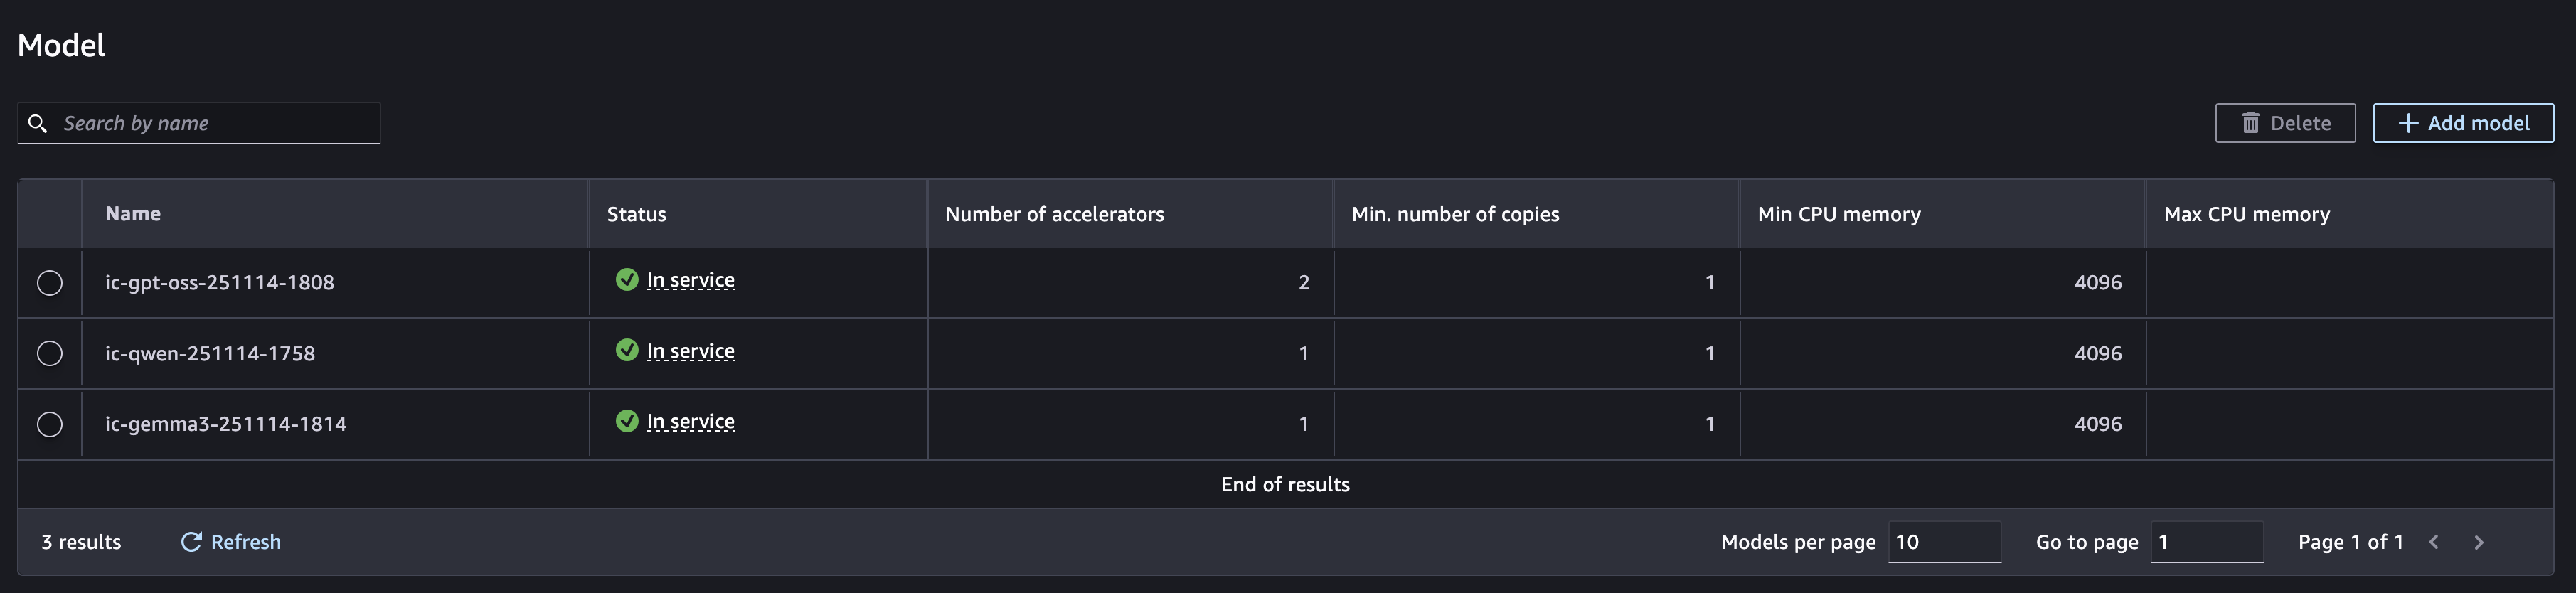

## Inference Examples

Please note different style and answer format of different models

### Qwen3-8B

In [49]:
payload={
    "messages": [
        {"role": "user", "content": "Name popular places to visit in London?"}
    ],
}

start_time = time.time()
res = smr_client.invoke_endpoint(EndpointName = endpoint_name,
                                 InferenceComponentName = qwen_ic_name,
                                 Body = json.dumps(payload),
                                 ContentType = "application/json")
response = json.loads(res["Body"].read().decode("utf8"))
end_time = time.time()

print(f"✅ Response time: {end_time-start_time:.2f}s\n")
display(Markdown(response["choices"][0]["message"]["content"]))

✅ Response time: 27.75s



<think>
Okay, the user is asking for popular places to visit in London. Let me start by recalling the major attractions. The British Museum is a must, it's free and has a lot of historical stuff. Then there's the Tower of London, which is iconic with the Crown Jewels. Big Ben and the Houses of Parliament are also famous, even though Big Ben is technically the clock tower. The London Eye is a modern landmark, great for a view of the city. 

Wait, I should mention the Westminster Abbey too, it's a historic church and a tourist spot. The National Gallery and the Tate Modern are both art museums, so they should be included. Maybe the Churchill War Rooms? That's a historical site. 

What about parks? Hyde Park and Kensington Gardens are big ones. The Thames River is a scenic spot, maybe mention a boat tour. The Shard is a modern building with a viewing platform. St. Paul's Cathedral is another must-see, especially the dome. 

Oh, and the British Museum is free, so that's a good point to highlight. Also, the Tower of London has the Crown Jewels, which is a big draw. The London Eye is a fun activity, especially at night. 

I should make sure not to miss any major spots. Maybe include the Victoria and Albert Museum if they're interested in design. The Natural History Museum is another big one. Wait, the user might be looking for a list that's comprehensive but not too long. Let me organize them by categories: historical, cultural, parks, modern landmarks, etc. 

Also, think about the user's possible needs. They might be planning a trip and want a variety of options. Maybe mention some tips, like the best times to visit or free attractions. But the question is just asking for popular places, so maybe keep it to the list. 

Check if I'm missing any key spots. The Houses of Parliament and Big Ben are often confused, but they should be together. The National Gallery and the Tate Modern are both in different areas. The Churchill War Rooms are in the basement of the Cabinet War Rooms. 

I think that's a solid list. Let me structure it with categories and brief descriptions, making sure to highlight the most iconic ones first. Maybe add a note about free attractions since some are free. That should cover the user's query effectively.
</think>

London is a city rich in history, culture, and iconic landmarks. Here are some of the most popular places to visit:

### **Historical & Cultural Attractions**
1. **British Museum**  
   - Free entry. Home to the Rosetta Stone, Egyptian mummies, and artifacts from around the world.

2. **Tower of London**  
   - Historic castle with the Crown Jewels, medieval history, and the Yeoman Warders (Beefeaters).

3. **Houses of Parliament & Big Ben**  
   - Iconic landmarks with stunning architecture and the famous clock tower.

4. **Westminster Abbey**  
   - Historic church where British monarchs are crowned and royal weddings take place.

5. **St. Paul’s Cathedral**  
   - A masterpiece of English Baroque architecture with a breathtaking dome.

6. **Churchill War Rooms**  
   - Secret bunker where Winston Churchill directed WWII efforts.

---

### **Art & Museums**
7. **National Gallery**  
   - World-class collection of European art, including works by Van Gogh, Rembrandt, and Turner.

8. **Tate Modern**  
   - A vibrant modern art museum housed in a former power station.

9. **Victoria and Albert Museum (V&A)**  
   - One of the world’s leading museums of art and design.

10. **Natural History Museum**  
    - Stunning architecture and exhibits on natural history, including the dinosaur skeletons.

---

### **Parks & Green Spaces**
11. **Hyde Park**  
    - A vast urban park with the Serpentine Lake, Speakers’ Corner, and the Diana, Princess of Wales Memorial Fountain.

12. **Kensington Gardens**  
    - Adjacent to Hyde Park, home to the Royal Albert Hall and the Kensington Palace.

13. **Regent’s Park**  
    - Features the London Zoo, open-air theatre, and beautiful gardens.

---

### **Modern & Iconic Landmarks**
14. **London Eye**  
    - Giant Ferris wheel offering panoramic views of the city.

15. **The Shard**  
    - A modern skyscraper with a viewing platform and a glass floor.

16. **Borough Market**  
    - A bustling market offering food from around the world.

17. **Covent Garden**  
    - A lively area with historic buildings, markets, and street performers.

---

### **Other Highlights**
18. **Oxford Street & Bond Street**  
    - Shopping destinations with flagship stores and high-end boutiques.

19. **Camden Market**  
    - A vibrant market with eclectic shops, food, and street art.

20. **The Thames River**  
    - Take a boat tour for scenic views or enjoy a riverside walk.

---

### **Tips**
- **Free Attractions**: The British Museum, National Gallery, and many parks are free.  
- **Best Times to Visit**: Avoid peak tourist seasons (July–August) for a more relaxed experience.  
- **Transport**: Use the London Underground (Tube) or buses for easy travel.

Let me know if you’d like recommendations for specific interests (e.g., food, history, art)! 🗽✨

### GPT-OSS-120B

In [50]:
payload={
    "messages": [
        {"role": "user", "content": "Name popular places to visit in London?"}
    ],
}

start_time = time.time()
res = smr_client.invoke_endpoint(EndpointName = endpoint_name,
                                 InferenceComponentName = gptoss_ic_name,
                                 Body = json.dumps(payload),
                                 ContentType = "application/json")
response = json.loads(res["Body"].read().decode("utf8"))
end_time = time.time()

print(f"✅ Response time: {end_time-start_time:.2f}s\n")
display(Markdown(response["choices"][0]["message"]["content"]))

✅ Response time: 15.10s



Here are some of the most popular sights and neighborhoods that visitors to London usually put at the top of their itineraries (with a quick note on what makes each spot worth a stop).

---

## Classic Landmarks
| Attraction | Why It’s Popular | Quick Tips |
|------------|------------------|------------|
| **The Tower of London** | Medieval fortress, Crown Jewels, Yeoman Warders (Beefeaters) | Get tickets online to skip the queue; allocate ~2 hrs. |
| **Buckingham Palace** | Official residence of the monarch; Changing of the Guard | Guard ceremony runs Mon‑Sat 11 am (weather‑dependent). |
| **Westminster Abbey** | Gothic church, coronations & royal weddings | Audio guide is excellent; dress modestly. |
| **Houses of Parliament & Big Ben** | Iconic neo‑Gothic building on the Thames | Best viewed from the South Bank or Westminster Bridge. |
| **St Paul’s Cathedral** | Massive dome, Whispering Gallery | Climb to the dome for a panoramic city view (≈30 min). |
| **The London Eye** | 30‑minute wheel ride with skyline vistas | Book “fast‑track” tickets if you’re short on time. |
| **The Shard** | Western Europe’s tallest building; observation deck “The View from The Shard” | Evening visits give spectacular city lights. |

---

## Museums & Galleries (Free Entry to Main Collections)
| Institution | Highlights | Practical Note |
|------------|------------|----------------|
| **British Museum** | Rosetta Stone, Egyptian mummies, Parthenon sculptures | Must‑see in 2 hrs; special exhibitions charge. |
| **Tate Modern** | Contemporary art, Turbine Hall installations | Free entry; consider the river‑front café for a break. |
| **National Gallery** | Masterpieces by Van Gogh, Da Vinci, Turner | Located in Trafalgar Square; audio guide available. |
| **Victoria & Albert Museum (V&A)** | Design, fashion, ceramics, photography | Large collection—focus on a floor or two. |
| **Natural History Museum** | Dinosaur skeletons, “Earth Hall” | Family‑friendly; free, but the “dino” exhibit often has a timed ticket. |
| **Science Museum** | Interactive science exhibits, “Wonderlab” | Great for kids; some special displays need a ticket. |
| **Imperial War Museum** | WWII artifacts, Holocaust exhibition | Free galleries; some temporary shows charge. |

---

## Royal & Historic Parks
| Park | Notable Features |
|------|------------------|
| **Hyde Park** | Serpentine lake, Speakers’ Corner, Diana Memorial Fountain |
| **Regent’s Park** | Open Air Theatre, London Zoo, beautiful rose gardens |
| **St James’s Park** | Views of Buckingham Palace, pelicans & a lake |
| **Greenwich Park** | Royal Observatory (Meridian Line), panoramic Thames view |
| **Kensington Gardens** | Kensington Palace, Italian Gardens, the Diana Memorial Playground |

---

## Unique Neighborhoods & Markets
| Area | What to Do |
|------|------------|
| **Covent Garden** | Street performers, boutique shops, historic market hall |
| **Camden Town** | Alternative fashion, live music, Camden Lock market (food & crafts) |
| **Notting Hill** | Colorful houses, Portobello Road Market (vintage & food) |
| **Shoreditch** | Street art (e.g., Brick Lane), trendy bars, Boxpark pop‑up mall |
| **Southbank** | Riverside promenade, cultural venues (Royal Festival Hall, Globe Theatre) |
| **West End (Leicester Square & Piccadilly)** | Theatres, cinema, bustling night life |
| **Brick Lane** | Curry houses, vintage shops, Saturday market |

---

## Theaters & Performances
| Venue | Typical Offerings |
|-------|-------------------|
| **Royal Opera House** (Covent Garden) | Opera & ballet |
| **National Theatre** (South Bank) | Contemporary and classic plays |
| **West End theatres** (Leicester Square, Shaftesbury Avenue) | Musicals like *The Lion King*, *Hamilton*, *Phantom of the Opera* |
| **Shakespeare’s Globe** (Bankside) | Re‑created Elizabethan playhouse; outdoor summer shows |

---

## Day‑Trip Gems (within 1–2 hrs by train)
| Destination | Reason to Visit |
|-------------|-----------------|
| **Windsor Castle** | Oldest and largest inhabited castle in the world |
| **Hampton Court Palace** | Henry VIII’s former residence, famous maze |
| **Oxford** | Historic university city, dreaming spires |
| **Cambridge** | Punting on the River Cam, stunning college architecture |
| **Brighton** | Seaside resort with pier, eclectic Lanes |
| **Bath** | Roman baths, Georgian architecture (a bit farther—≈2.5 hrs)** |

---

### Quick Planning Tips

| Tip | Details |
|-----|----------|
| **Transport** | Get an **Oyster card** or use contactless pay for the Tube, buses, and DLR. Day Travelcard (£7.70 for zones 1‑2) can be cheaper for heavy use. |
| **Peak Times** | Early mornings (8–9 am) and late afternoons (after 5 pm) are less crowded at major museums. |
| **Tickets** | Pre‑book timed‑entry tickets for **Tower of London, London Eye, The Shard, and major exhibitions** to avoid long lines. |
| **Weather** | London weather can be changeable; keep a compact umbrella and waterproof shoes handy. |
| **Dining** | For a quick bite, try **street food markets** (Borough Market, Maltby Street, Southbank Centre Food Market). For a “proper” British pub experience, head to **The Churchill Arms (Kensington)** or **The Blackfriar (Fleet Street)**. |
| **Walking** | Many attractions in Central London are within walking distance; a good pair of comfortable shoes is essential. |

---

**Bottom line:** London offers a blend of history, art, green spaces, and vibrant neighborhoods. Pick a mix that matches your interests—whether it’s royal pomp, world‑class museums, or quirky market vibes—and you’ll have a memorable stay! Safe travels!

### Gemma3-4B

In [51]:
payload={
    "messages": [
        {"role": "user", "content": "Name popular places to visit in London?"}
    ],
}

start_time = time.time()
res = smr_client.invoke_endpoint(EndpointName = endpoint_name,
                                 InferenceComponentName = gemma3_ic_name,
                                 Body = json.dumps(payload),
                                 ContentType = "application/json")
response = json.loads(res["Body"].read().decode("utf8"))
end_time = time.time()

print(f"✅ Response time: {end_time-start_time:.2f}s\n")
display(Markdown(response["choices"][0]["message"]["content"]))

✅ Response time: 15.29s



Okay, let's break down popular places to visit in London! There's a *ton* to see and do, so I'll categorize them for easier browsing:

**1. Iconic Landmarks & Tourist Essentials:**

* **Buckingham Palace:** Witness the Changing of the Guard ceremony (check the schedule in advance!). Tours are available during the summer months.
* **Tower of London:**  Historic castle, home to the Crown Jewels, and steeped in fascinating (and often gruesome) history.
* **Tower Bridge:** Iconic bridge with a fascinating exhibition about its construction and operation.  Walk across the high-level walkways for stunning views.
* **Big Ben & Houses of Parliament:** (Officially Elizabeth Tower)  The famous clock tower and the seat of British government. Currently undergoing renovations, so views might be limited.
* **London Eye:** Giant Ferris wheel offering panoramic views of the city. 
* **St. Paul’s Cathedral:**  A magnificent cathedral with breathtaking architecture and historical significance.


**2. Museums & Galleries (Many are FREE!):**

* **British Museum:**  World-renowned museum with artifacts from around the globe (Egyptian mummies, Rosetta Stone, etc.).
* **National Gallery:**  Home to a vast collection of European paintings from the 13th to 19th centuries.
* **Tate Modern:** Modern and contemporary art museum housed in a former power station.
* **Victoria and Albert Museum (V&A):**  Decorative arts and design museum – fashion, furniture, ceramics, jewelry, etc.
* **Natural History Museum:** Dinosaurs, animals, and geological specimens – perfect for families.
* **Science Museum:** Interactive exhibits exploring science and technology.
* **Churchill War Rooms:**  Underground headquarters used during World War II.



**3. Parks & Green Spaces:**

* **Hyde Park:** One of London's largest parks, offering boating, cycling, and walking paths.
* **Regent's Park:** Home to London Zoo, an open-air theatre, and beautiful rose gardens.
* **St. James's Park:**  Beautiful park near Buckingham Palace, perfect for a relaxing stroll.
* **Greenwich Park:** Offers stunning views of the city skyline and the Royal Observatory (where the Prime Meridian passes through).
* **Richmond Park:**  Large royal park with wild deer roaming freely.



**4. Shopping & Entertainment:**

* **Oxford Street:**  Famous shopping street with a huge variety of stores.
* **Regent Street:**  More upscale shopping with flagship stores and beautiful architecture.
* **Carnaby Street:**  Trendy and independent shops.
* **Covent Garden:**  Street performers, shops, restaurants, and the Royal Opera House.
* **Soho:**  Known for its nightlife, restaurants, theatres, and diverse cultural scene.
* **Leicester Square:**  Theatre district and home to cinemas.



**5. Unique Experiences:**

* **Shakespeare's Globe:**  Reconstructed Elizabethan theatre offering tours and performances.
* **Kensington Palace:** Former home of Princess Diana and current residence of the Prince and Princess of Wales.
* **Notting Hill:**  Colorful houses, Portobello Road Market (antiques and vintage), and a charming atmosphere.
* **Shoreditch:**  Trendy area with street art, independent shops, and vibrant nightlife.
* **Camden Town:**  Alternative culture, markets, music venues, and a unique atmosphere.
* **Warner Bros. Studio Tour London - The Making of Harry Potter:** (Located just outside London) – A must for Harry Potter fans.

**Resources for Planning:**

* **Visit London:** [https://www.visitlondon.com/](https://www.visitlondon.com/) - Official tourism website with lots of information.
* **Time Out London:** [https://www.timeout.com/london](https://www.timeout.com/london) -  Reviews and listings for events, restaurants, and things to do.

**To help me narrow down recommendations for *you*, could you tell me:**

*   **Who are you traveling with?** (e.g., family with young children, couple, solo traveler)
*   **What are your interests?** (e.g., history, art, food, shopping, theatre)
*   **What's your budget like?** (e.g., budget-friendly, mid-range, luxury)

## Reasoning question

### Gwen3-8B

In [52]:
payload={
    "messages": [
        {"role": "user", "content": "How many times does the letter b appear in blueberry"}
    ],
}

start_time = time.time()
res = smr_client.invoke_endpoint(EndpointName = endpoint_name,
                                 InferenceComponentName = qwen_ic_name,
                                 Body = json.dumps(payload),
                                 ContentType = "application/json")
response = json.loads(res["Body"].read().decode("utf8"))
end_time = time.time()

print(f"✅ Response time: {end_time-start_time:.2f}s\n")
display(Markdown(response["choices"][0]["message"]["content"]))

✅ Response time: 37.39s



<think>
Okay, let's see. The user is asking how many times the letter 'b' appears in the word "blueberry". Hmm, first I need to make sure I have the correct spelling of the word. Let me write it out: B-L-U-E-B-E-R-R-Y. Wait, is that right? Let me check again. B-L-U-E-B-E-R-R-Y. Yeah, that's blueberry. Now, I need to count the number of times the letter 'b' appears.

Starting from the beginning: the first letter is 'B', so that's one. Then the next letters are L, U, E, so no 'b's there. Then comes another 'B' after the E. So that's the second 'b'. Then the rest of the letters are R, R, Y. So after the second 'b', there are no more 'b's. Let me count again to make sure I didn't miss any. B (1), then the next 'b' is the fifth letter. So total of two 'b's? Wait, wait, let me write it out with positions:

1: B
2: L
3: U
4: E
5: B
6: E
7: R
8: R
9: Y

So positions 1 and 5 have 'B's. That's two times. Wait, but sometimes people might miss the case sensitivity. But the question says "the letter b", so it's case-insensitive? But the original word is written with a capital B, but the question is about the lowercase 'b'? Wait, the word is "blueberry", which starts with a capital B, but in the actual word, the letters are B, L, U, E, B, E, R, R, Y. So the first letter is uppercase, but the rest are lowercase. However, the question is about the letter 'b', which is lowercase. But in the word, the first 'B' is uppercase, but the second 'b' is lowercase. Wait, does that matter? The question says "the letter b", so maybe it's case-sensitive. But in the word "blueberry", the first letter is uppercase, so maybe it's considered a 'B' and the second is lowercase 'b'. So if the question is case-sensitive, then the first 'B' is not counted as 'b', but the second 'b' is. Wait, but the user wrote the word as "blueberry", which is a common spelling with the first letter capitalized. However, in the context of the question, they might be referring to the lowercase 'b's. But in the actual word, there's one uppercase 'B' and one lowercase 'b'? Wait, no. Let me think again. The word "blueberry" is typically written with the first letter capitalized, so the first letter is 'B' (uppercase), and the rest are lowercase. So the letters are: B, l, u, e, b, e, r, r, y. So the first 'B' is uppercase, and the second 'b' is lowercase. So if the question is about the lowercase 'b', then only the second one counts. But if it's case-insensitive, then both count. But the question says "the letter b", which is lowercase. So maybe the answer is 1? But that seems odd. Wait, maybe the user is not considering case sensitivity. Let me check again. The original word is "blueberry", which is a proper noun? No, it's a common noun. So in standard usage, it's written with the first letter capitalized, but the rest lowercase. So the letters are B, l, u, e, b, e, r, r, y. So the first 'B' is uppercase, the second 'b' is lowercase. So if the question is case-sensitive, then only the lowercase 'b' counts, which is one. But if it's case-insensitive, then both 'B' and 'b' are considered, so two. But the question says "the letter b", which is lowercase. So maybe the answer is one. But I need to be careful here. Wait, maybe the user is not considering case sensitivity. For example, in many contexts, people might not distinguish between uppercase and lowercase when counting letters. So maybe they just want to know how many times the letter 'b' appears regardless of case. In that case, both the first 'B' and the second 'b' would count, making it two. But I need to check the exact wording. The question is: "How many times does the letter b appear in blueberry". The letter 'b' is lowercase, but the word "blueberry" has an uppercase 'B' as the first letter. So if the question is case-sensitive, then only the second 'b' counts. But if it's case-insensitive, then both count. However, in most cases, when people ask this type of question, they are case-insensitive. For example, if you search for how many times 'b' appears in "blueberry", it's usually two. So maybe the answer is two. Wait, but maybe the user is using the word as written, which is "blueberry" with the first letter capitalized. So the letters are B, l, u, e, b, e, r, r, y. So the 'B' is uppercase, and the 'b' is lowercase. So if the question is about the lowercase 'b', then only the second one. But in reality, when people count letters, they usually don't consider case. For example, in the word "Blueberry", the 'B' is considered a 'b' when counting. So the answer is two. Therefore, I think the correct answer is two. But to be thorough, I should check both possibilities. Let me confirm. If the word is written as "Blueberry" (with a capital B), then the letters are B, l, u, e, b, e, r, r, y. So the first letter is uppercase B, and the fifth letter is lowercase b. So if the question is about the letter 'b' regardless of case, then two. If it's about lowercase 'b', then one. But the question says "the letter b", which is lowercase. So maybe the answer is one. However, in practice, people often count both cases. For example, in the word "Blueberry", the count would be two. So perhaps the answer is two. To resolve this, maybe I should consider that the user is not case-sensitive, so the answer is two. Alternatively, maybe the user made a typo and intended to write "blueberry" with all lowercase letters. But since the user wrote "blueberry" with a capital B, it's possible. Hmm. I think the safest answer is two, considering that in most contexts, case is ignored. So the answer is 2.
</think>

The letter **b** appears **2 times** in "blueberry". 

Here's the breakdown:
- The first **B** (uppercase) and the second **b** (lowercase) are both counted as **b** when case is ignored.  
- If case sensitivity is considered, the uppercase **B** might not be counted, but in standard practice, letter counts are typically case-insensitive.  

**Answer:** 2 times.

### GPT-OSS-120B

In [53]:
payload={
    "messages": [
        {"role": "user", "content": "How many times does the letter b appear in blueberry"}
    ],
}
start_time = time.time()
res = smr_client.invoke_endpoint(EndpointName = endpoint_name,
                                 InferenceComponentName = gptoss_ic_name,
                                 Body = json.dumps(payload),
                                 ContentType = "application/json")
response = json.loads(res["Body"].read().decode("utf8"))
end_time = time.time()

print(f"✅ Response time: {end_time-start_time:.2f}s\n")
display(Markdown(response["choices"][0]["message"]["content"]))

✅ Response time: 1.75s



The letter **b** appears **2 times** in the word **“blueberry.”**

### Gemma3-4B

In [54]:
payload={
    "messages": [
        {"role": "user", "content": "How many times does the letter b appear in blueberry"}
    ],
}

start_time = time.time()
res = smr_client.invoke_endpoint(EndpointName = endpoint_name,
                                 InferenceComponentName = gemma3_ic_name,
                                 Body = json.dumps(payload),
                                 ContentType = "application/json")
response = json.loads(res["Body"].read().decode("utf8"))
end_time = time.time()

print(f"✅ Response time: {end_time-start_time:.2f}s\n")
display(Markdown(response["choices"][0]["message"]["content"]))

✅ Response time: 0.52s



The letter "b" appears 2 times in the word "blueberry". 

Let me know if you'd like to try another word!

### Streaming example (Qwen3-8B)

In [55]:
import io
import time
from IPython.display import clear_output

class LineIterator:
    def __init__(self, stream):
        self.byte_iterator = iter(stream)
        self.buffer = io.BytesIO()
        self.read_pos = 0

    def __iter__(self):
        return self

    def __next__(self):
        while True:
            self.buffer.seek(self.read_pos)
            line = self.buffer.readline()
            if line and line[-1] == ord("\n"):
                self.read_pos += len(line)
                return line[:-1]
            try:
                chunk = next(self.byte_iterator)
            except StopIteration:
                if self.read_pos < self.buffer.getbuffer().nbytes:
                    continue
                raise
            if "PayloadPart" not in chunk:
                print("Unknown event type:" + chunk)
                continue
            self.buffer.seek(0, io.SEEK_END)
            self.buffer.write(chunk["PayloadPart"]["Bytes"])

def stream_response(endpoint_name, inputs, max_tokens=8189, temperature=0.7, top_p=0.9):
    body = {
      "messages": [
        {"role": "user", "content": [{"type": "text", "text": inputs}]}
        ],
        "max_tokens": max_tokens,
        "temperature": temperature,
        "top_p": top_p,
        "stream": True,
    }

    resp = smr_client.invoke_endpoint_with_response_stream(
        EndpointName=endpoint_name,
        Body=json.dumps(body),
        ContentType="application/json",
        InferenceComponentName=qwen_ic_name
    )

    event_stream = resp["Body"]
    start_json = b"{"
    full_response = ""
    start_time = time.time()
    token_count = 0

    for line in LineIterator(event_stream):
        if line != b"" and start_json in line:
            data = json.loads(line[line.find(start_json):].decode("utf-8"))
            token_text = data['choices'][0]['delta'].get('content', '')
            full_response += token_text
            token_count += 1

            # Calculate tokens per second
            elapsed_time = time.time() - start_time
            tps = token_count / elapsed_time if elapsed_time > 0 else 0

            # Clear the output and reprint everything
            clear_output(wait=True)
            print(full_response)
            print(f"\nTokens per Second: {tps:.2f}", end="")

    print("\n") # Add a newline after response is complete

    return full_response

In [56]:
inputs = "How many times does the letter b appear in blueberry"
output = stream_response(endpoint_name, inputs, max_tokens=8000)

<think>
Okay, let's see. The user is asking how many times the letter 'b' appears in the word "blueberry". Hmm, first I need to make sure I spell the word correctly. Blueberry... right, B-L-U-E-B-E-R-R-Y. Wait, let me check that again. B, L, U, E, B, E, R, R, Y. So that's nine letters total. Now, I need to count the number of 'b's. Let me go through each letter one by one.

Starting with the first letter: B. That's one 'b'. Then the next letters are L, U, E, so no 'b's there. Then the fifth letter is B again. So that's the second 'b'. The rest of the letters are E, R, R, Y. No more 'b's. So total of two 'b's. Wait, but wait, maybe I should write it out to make sure. Let me write the letters with their positions:

1. B
2. L
3. U
4. E
5. B
6. E
7. R
8. R
9. Y

Yes, so positions 1 and 5 are 'b's. That's two times. Wait, but sometimes people might confuse the 'b' in the middle. Let me check again. Blueberry is spelled B-L-U-E-B-E-R-R-Y. So the first 'b' is at the start, then after the 'e' 

## Cleanup

In [57]:
sess.delete_inference_component(qwen_ic_name, wait=True)
sess.delete_inference_component(gptoss_ic_name, wait=True)
sess.delete_inference_component(gemma3_ic_name, wait=True)
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
sess.delete_model(qwen_model_name)
sess.delete_model(gptoss_model_name)
sess.delete_model(gemma3_model_name)